## Starter Code

In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# Enter the filename where the project
FOLDERNAME = 'CS231n Project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Import sys so we can access utils files with imports.
# ie utils_ade20k in next code block.
import sys

Mounted at /content/drive


In [2]:
# Starter setup
# !sh /content/drive/MyDrive/CS231n\ Project/Python\ Scripts/setup.sh
sys.path.insert(0,'/content/drive/My Drive/CS231n Project/Python Scripts/')

In [3]:
# Colab is making us import ipdb everytime for utils_ade20k import.
!pip install ipdb
%load_ext autoreload
%autoreload 2
# Imports
import imageio
from PIL import Image, ImageOps
import IPython.display
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pickle as pkl
# File provided by MIT researchers. Important for image parsing below.
import utils_ade20k
from get_ade20k_data import *

     |████████████████████████████████| 788kB 14.4MB/s 
     |████████████████████████████████| 368kB 54.7MB/s 
  Created wheel for ipdb: filename=ipdb-0.13.7-cp37-none-any.whl size=11434 sha256=63c3cc64be142ebdb2689a3b81043ca3b88eb73727bf8235338a881b72049d48
  Stored in directory: /root/.cache/pip/wheels/69/e2/66/bde554f8029ad1c5288f3bf427a78b18ec670182d7e670efe6
Successfully built ipdb
ERROR: jupyter-console 5.2.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 3.0.18 which is incompatible.
ERROR: google-colab 1.0.0 has requirement ipython~=5.5.0, but you'll have ipython 7.23.1 which is incompatible.
  Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0


## Data Index

In [4]:
# Load index with global information about ADE20K
DATASET_PATH = '/content/drive/MyDrive/CS231n Project/Datasets'
# This is the name of the pkl file used to parse through the files.
index_file = 'index_ade20k.pkl'
# Open the pkl file at dataset path and index file denoted above.
with open('{}/{}'.format(DATASET_PATH, index_file), 'rb') as f:
    index_ade20k = pkl.load(f)

In [23]:
# The pkl file is loaded, printing description of the entire dataset.
print("File loaded, description of the attributes:")
print('--------------------------------------------')
# notice key 'description' gives us high level image attributes.
for attribute_name, desc in index_ade20k['description'].items():
    print('* {}: {}'.format(attribute_name, desc))
print('--------------------------------------------\n')

# i is the image number No idea for how they parse through it ie
# how many in train or validation. 
i = 16964 # 16899, 16964
# n files in the dataset.
nfiles = len(index_ade20k['filename'])
# name of the file at index i (index_ade20k['filename'] is a list)
file_name = index_ade20k['filename'][i]
# The number of objects (instances) in the image.
num_obj = index_ade20k['objectPresence'][:, i].sum()
# Object is a part (ie it's a smaller object within larger object)
num_parts = index_ade20k['objectIsPart'][:, i].sum()
# The object that appears the most.
count_obj = index_ade20k['objectPresence'][:, i].max()

# The id of the object?
obj_id = np.where(index_ade20k['objectPresence'][:, i] == count_obj)[0][0]
# Get the name of the object (wall)
obj_name = index_ade20k['objectnames'][obj_id]
# Get the full filename (from root to end path)
full_file_name = '{}/{}'.format(index_ade20k['folder'][i], index_ade20k['filename'][i])
if 'training' in full_file_name:
  print('Training')
else:
  print('Validation')
# Description of all this stuff below.
print("The dataset has {} images".format(nfiles))
print("The image at index {} is {}".format(i, file_name))
print("It is located at {}".format(full_file_name))
print("It happens in a {}".format(index_ade20k['scene'][i]))
print('Number of scenes: {}'.format(len(index_ade20k['scene'])))

print("It has {} objects, of which {} are parts".format(num_obj, num_parts))
print("The most common object is object {} ({}), which appears {} times".format(obj_name, obj_id, count_obj))

File loaded, description of the attributes:
--------------------------------------------
* filename: array of length N=27574 with the image file names
* folder: array of length N with the image folder names.
* scene: array of length N providing the scene name (same classes as the Places database) for each image.
* objectIsPart: array of size [C, N] counting how many times an object is a part in each image. objectIsPart[c,i]=m if in image i object class c is a part of another object m times. For objects, objectIsPart[c,i]=0, and for parts we will find: objectIsPart[c,i] = objectPresence(c,i)
* objectPresence: array of size [C, N] with the object counts per image. objectPresence(c,i)=n if in image i there are n instances of object class c.
* objectcounts: array of length C with the number of instances for each object class.
* objectnames: array of length C with the object class names.
* proportionClassIsPart: array of length C with the proportion of times that class c behaves as a part. 

## Loading a segmentation object

We will visualize the same object we were studying before

Seg shape in utils: (1650, 2200, 3)
The object name is: traffic light
The object instance is: 1
The object location/polygon is: {'x': array([233, 274, 271, 231]), 'y': array([648, 648, 760, 759])}
(1650, 2200, 3)
(1650, 2200)
[  0  42  46  47  48  49  53  61  63  64  65  67  68  69  70  71  72  73
  74  78  84  90  91  92  93  94  95  96  97 102 103 115 139]


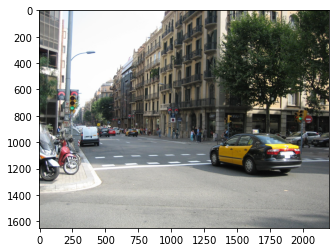

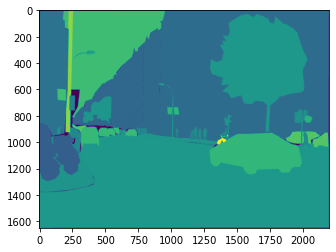

In [24]:
# Get the root path here.
root_path = DATASET_PATH
# loads image at the root_path + full_file_name (starting from root).
info = utils_ade20k.loadAde20K('{}/{}'.format(root_path, full_file_name))
# img is the image itself
print('The object name is: {}'.format(info['objects']['class'][1]))
print('The object instance is: {}'.format(info['objects']['instancendx'][1]))
print('The object location/polygon is: {}'.format(info['objects']['polygon'][1]))
# plt.plot(info['objects']['polygon'][1]['x'], info['objects']['polygon'][1]['y'])
img = cv2.imread(info['img_name'])[:,:,::-1]
# seg is a segmentation image
seg = Image.open(info['segm_name'])

plt.imshow(np.array(img))
plt.figure()
print(np.array(seg).shape)
plt.imshow(ImageOps.grayscale(seg))
print(np.array(ImageOps.grayscale(seg)).shape)
print(np.unique(np.array(ImageOps.grayscale(seg))))


## Amodal segmentation and Polygons

We also provide access to the original polygons annotated, as well as the amodal segmentation of object instances

(-0.5, 1649.5, 365.5, -0.5)

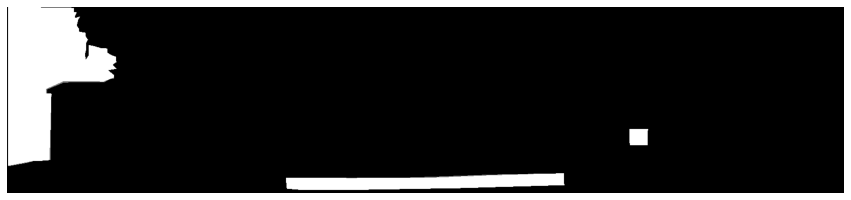

In [ ]:
# We have a segmentation for every object instance, showing object bounds without occlusions
instances = [1, 8, 12]
images = []
# For each instance.
for instance in instances:
    # This is how you get the file instane which you read the image from.
    file_instance = '{}/{}/instance_{:03}_{}'.format(
        root_path, full_file_name.replace('.jpg', ''), instance, file_name.replace('.jpg', '.png'))
    # read in the instance
    aux = cv2.imread(file_instance)
    # append it to the images to plot
    images.append(aux)
plt.figure(figsize=(5*len(images), 5))
plt.imshow(np.concatenate(images, 1))
plt.axis('off')

Finally, we can get the original polygons:

(-0.5, 549.5, 365.5, -0.5)

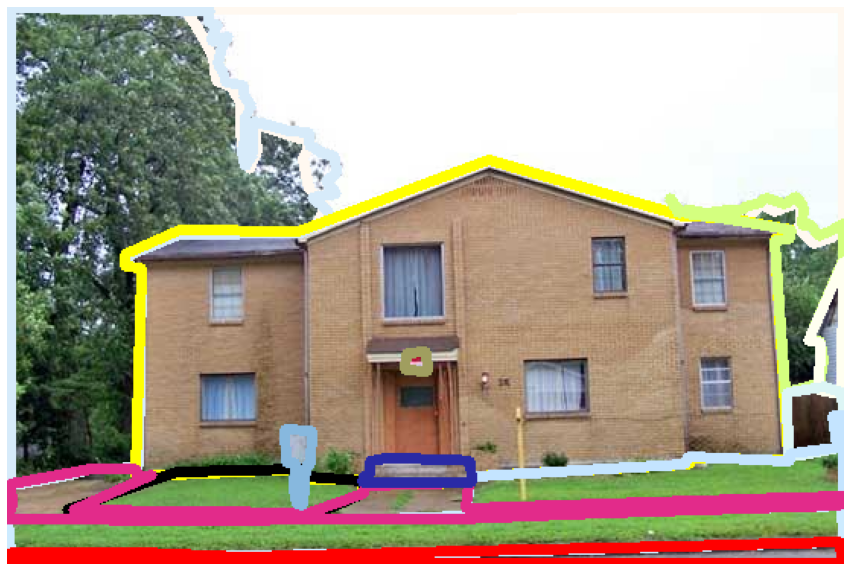

In [ ]:
# uses the plot_polygon function to have objects drawn.
img = utils_ade20k.plot_polygon('{}/{}'.format(root_path, full_file_name), info)
# Plot the figure.
plt.figure(figsize=(15,15))
plt.imshow(img[:, :, ::-1])
plt.axis('off')

In [ ]:
path = '/content/drive/My Drive/CS231n Project/Datasets/'
data = None
data = get_ade20k_data(path)
for k, v in data.items():
  print('{} shape: {}'.format(k, v.shape))

x_train shape: (13181, 128, 128, 3)
x_val shape: (1369, 128, 128, 3)
x_test shape: (1211, 128, 128, 3)
y_train_seg shape: (13181, 128, 128, 1)
y_val_seg shape: (1369, 128, 128, 1)
y_test_seg shape: (1211, 128, 128, 1)
y_train_scenes shape: (13181,)
y_val_scenes shape: (1369,)
y_test_scenes shape: (1211,)


In [ ]:
i2s_file = open(path + 'index_to_scene.pkl', 'rb')
index_to_scene = pkl.load(i2s_file)
i2s_file.close()
for k, v in index_to_scene.items():
  print('{}: {}'.format(k, v))

0: lake
1: poolroom
2: field
3: attic
4: childs_room
5: skyscraper
6: art_gallery
7: building_facade
8: mountain
9: garage
10: desert
11: mountain_snowy
12: beach
13: utliers
14: pasture
15: ocean
16: castle
17: office
18: coast
19: art_studio
20: nursery
21: corridor
22: park
23: alley
24: dining_room
25: hotel_room
26: dorm_room
27: conference_room
28: dinette
29: bedroom
30: isc
31: home_office
32: highway
33: kitchen
34: apartment_building
35: closet
36: waiting_room
37: house
38: airport_terminal
39: game_room
40: museum
41: parlor
42: bathroom
43: living_room
44: waterfall
45: forest
46: street
47: lobby
48: bakery
49: staircase


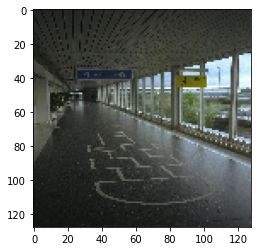

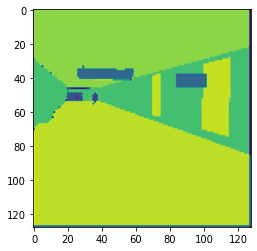

In [ ]:
plt.imshow(data['x_val'][0].astype(int))
plt.figure()
plt.imshow(data['y_val_seg'][0].astype(int).reshape(128, 128))